In [1]:
# === IMPORTS ===
import os
import re
import string
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, silhouette_score, adjusted_rand_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from xgboost import XGBClassifier
from joblib import Parallel, delayed

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# **Import the Data**

In [2]:
# === DATASET DOWNLOAD & LOADING ===
import kagglehub

# Download dataset and get local path
dataset_path = kagglehub.dataset_download("alexandrakim2201/spotify-dataset")
print("Path to dataset files:", dataset_path)

# List files in dataset folder and find CSV file
files = os.listdir(dataset_path)
print("Available files:", files)

csv_files = [f for f in files if f.endswith(".csv")]

if csv_files:
    data_file_path = os.path.join(dataset_path, csv_files[0])
    data = pd.read_csv(data_file_path)
    print("Dataset loaded successfully!")
    print(data.head())

    # Save a copy locally
    data.to_csv("spotify_dataset_saved.csv", index=False)
    print("Dataset saved as spotify_dataset_saved.csv")
else:
    raise FileNotFoundError("No CSV file found in the dataset.")

Path to dataset files: /kaggle/input/spotify-dataset
Available files: ['DATASET.csv']
Dataset loaded successfully!
                                              Review     label
0  Great music service, the audio is high quality...  POSITIVE
1  Please ignore previous negative rating. This a...  POSITIVE
2  This pop-up "Get the best Spotify experience o...  NEGATIVE
3    Really buggy and terrible to use as of recently  NEGATIVE
4  Dear Spotify why do I get songs that I didn't ...  NEGATIVE
Dataset saved as spotify_dataset_saved.csv


# **Exploring the Data**

In [3]:
# === DATA EXPLORATION ===

print("\nDataset info:")
data.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


In [4]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Review    16
label      0
dtype: int64


In [5]:
# Drop rows with missing values
data_cleaned = data.dropna()
print("\nMissing values after dropping rows with NaNs:")
print(data_cleaned.isnull().sum())

print(f"\nShape before dropping missing: {data.shape}")
print(f"Shape after dropping missing: {data_cleaned.shape}")


Missing values after dropping rows with NaNs:
Review    0
label     0
dtype: int64

Shape before dropping missing: (52702, 2)
Shape after dropping missing: (52686, 2)


In [6]:
print("\nStatistical description of cleaned data:")
print(data_cleaned.describe())


Statistical description of cleaned data:
       Review     label
count   52686     52686
unique  51472         2
top      Good  NEGATIVE
freq      153     29423


In [7]:
# Check distribution of target labels
label_counts = data_cleaned['label'].value_counts()
print("\nSentiment label distribution:")
print(label_counts)


Sentiment label distribution:
label
NEGATIVE    29423
POSITIVE    23263
Name: count, dtype: int64


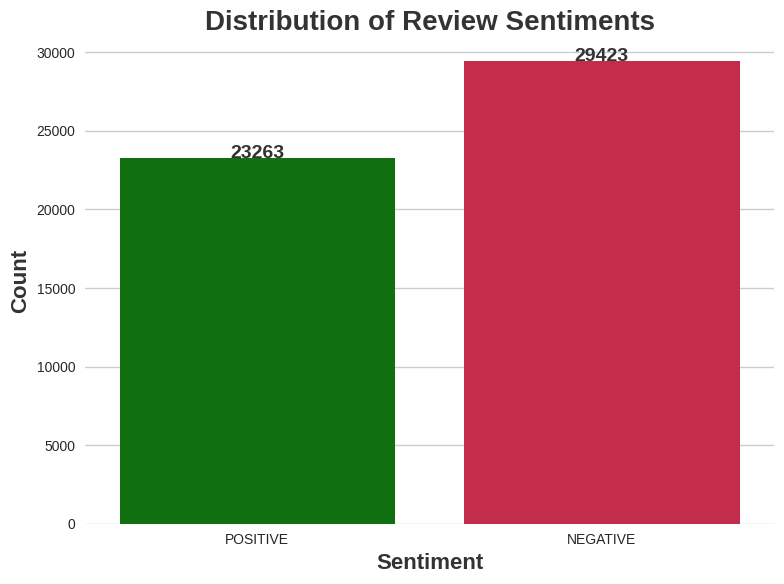

In [8]:
# Plot sentiment distribution
plt.figure(figsize=(8,6))
palette = ['#008000', '#DC143C']  # Emerald green and strawberry red

ax = sns.countplot(x='label', data=data_cleaned, hue='label', palette=palette, dodge=False, legend=False)
plt.title("Distribution of Review Sentiments", fontsize=20, fontweight='bold', color='#333333')
plt.xlabel("Sentiment", fontsize=16, fontweight='bold', color='#333333')
plt.ylabel("Count", fontsize=16, fontweight='bold', color='#333333')

# Add count annotations above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 15, f'{int(height)}',
            ha='center', fontsize=14, fontweight='bold', color='#333333')

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

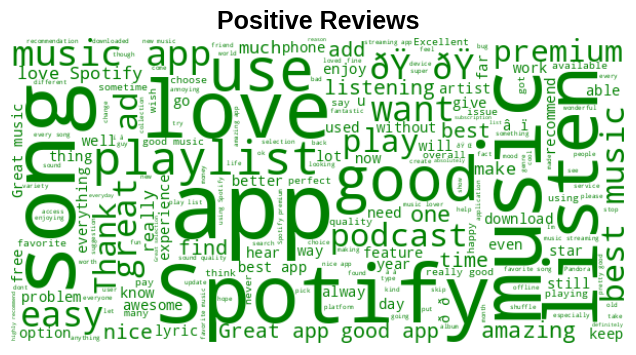

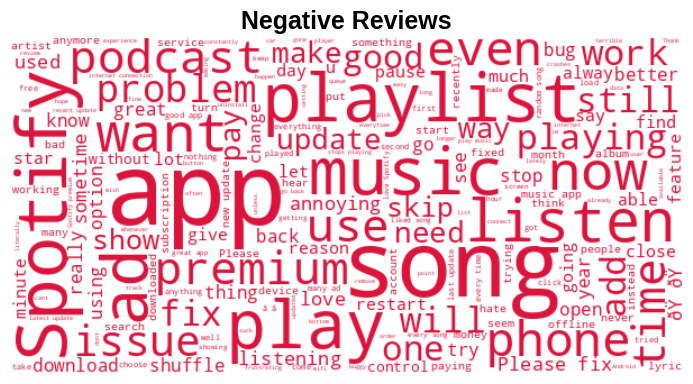

In [9]:
# === WORDCLOUD VISUALIZATION FOR SENTIMENTS ===

# Concatenate all reviews by sentiment
positive_text = ' '.join(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Review'])
negative_text = ' '.join(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Review'])

# Define custom color functions for word clouds
def emerald_green_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#008000"  # Emerald green

def strawberry_red_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#DC143C"  # Strawberry red

# Generate word clouds
positive_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkgreen',
    colormap=None
).generate(positive_text)

negative_wordcloud = WordCloud(
    background_color="white",
    max_words=200,
    max_font_size=90,
    width=600,
    height=300,
    contour_width=3,
    contour_color='darkred',
    colormap=None
).generate(negative_text)

# Plot positive word cloud
plt.figure(figsize=(8, 4))
plt.imshow(positive_wordcloud.recolor(color_func=emerald_green_color), interpolation="bilinear")
plt.title("Positive Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

# Plot negative word cloud
plt.figure(figsize=(8, 4))
plt.imshow(negative_wordcloud.recolor(color_func=strawberry_red_color), interpolation="bilinear")
plt.title("Negative Reviews", fontsize=18, fontweight='bold', color="#000000")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Preprocessing the Data**

In [10]:
# === TEXT PREPROCESSING ===

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Custom stopwords specific to the domain
custom_stopwords = {'spotify', 'music', 'song', 'songs', 'app'}

# Define stopwords set with negation exceptions
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}

# Merge stopwords with custom ones
all_stopwords = stop_words.union(custom_stopwords)

def clean_text(text):
    """
    Clean and preprocess text by:
    - Removing non-ascii characters
    - Lowercasing
    - Removing punctuation and digits
    - Removing stopwords (with exceptions)
    - Stripping leading and trailing spaces
    """
    # Remove non-ascii characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([c for c in text if not c.isdigit()])
    # Keep only alphabetic characters and spaces
    text = ''.join(filter(lambda x: x.isalpha() or x.isspace(), text))
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    cleaned_text = ' '.join(tokens)
    # Strip leading and trailing spaces
    return cleaned_text.strip()


# Apply cleaning function to review texts
data_cleaned['Cleaned_Review'] = data_cleaned['Review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


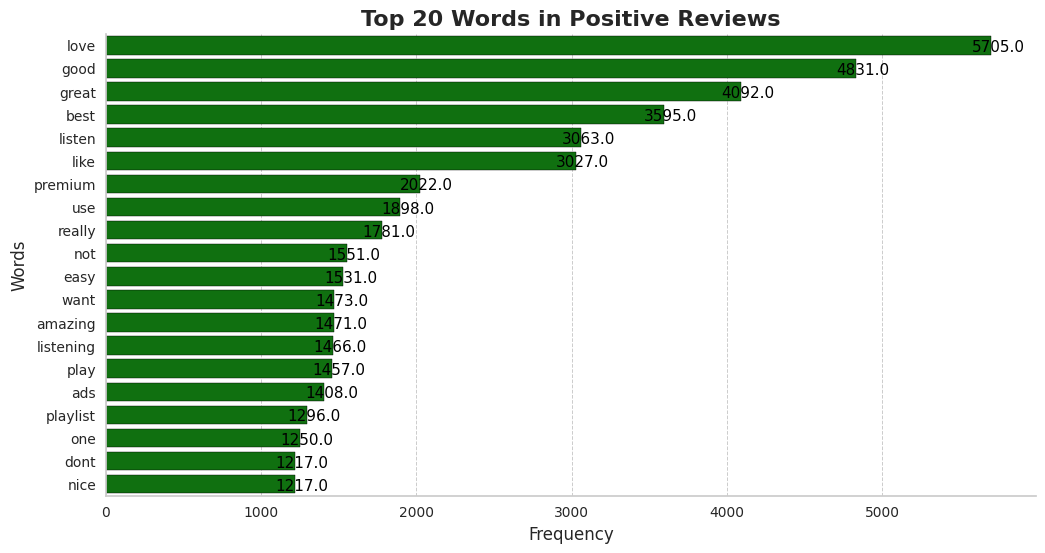

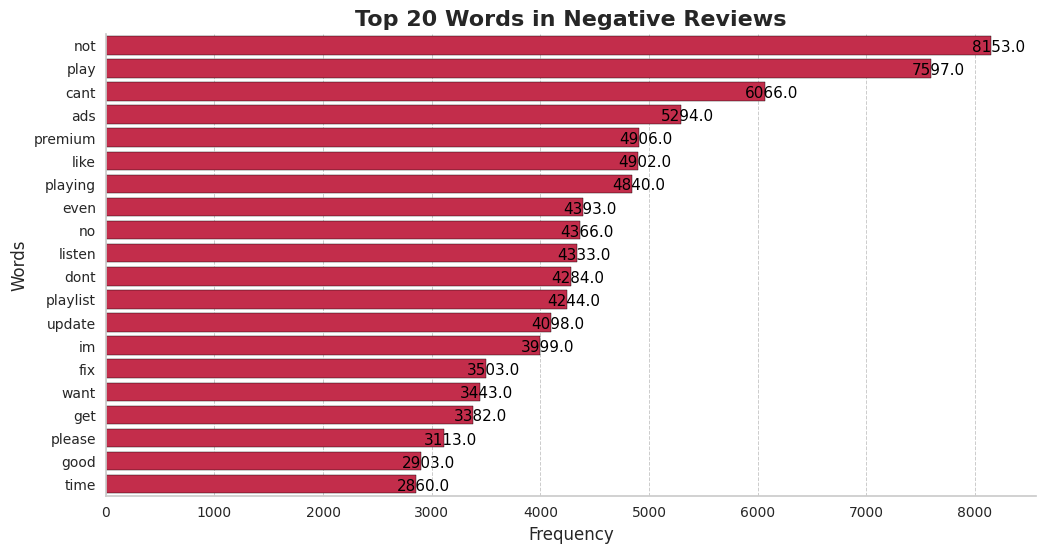

In [11]:
# === TOP WORDS ANALYSIS ===

sns.set_style("whitegrid")

def get_top_words(text_series, n=20):
    """
    Extract top n most frequent words from a series of texts.
    """
    all_words = ' '.join(text_series)
    tokens = all_words.split()
    counter = Counter(tokens)
    return counter.most_common(n)

# Get top 20 words for each sentiment
top_positive = get_top_words(data_cleaned[data_cleaned['label'] == 'POSITIVE']['Cleaned_Review'], 20)
top_negative = get_top_words(data_cleaned[data_cleaned['label'] == 'NEGATIVE']['Cleaned_Review'], 20)

def plot_top_words(top_words, title, color):
    """
    Plot a horizontal bar chart of the most frequent words.
    """
    words, counts = zip(*top_words)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=list(counts), y=list(words), color=color, edgecolor='black')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)

    # Annotate bars with count values
    for p in ax.patches:
        ax.annotate(f'{p.get_width()}', (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center_baseline', fontsize=11, color='black', xytext=(5, 0),
                    textcoords='offset points')

    sns.despine()
    plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
    plt.show()

# Colors for plots
emerald_green = '#008000'
strawberry_red = '#DC143C'

# Plot top words for positive and negative reviews
plot_top_words(top_positive, 'Top 20 Words in Positive Reviews', emerald_green)
plot_top_words(top_negative, 'Top 20 Words in Negative Reviews', strawberry_red)

# **3) Text Representation: SBERT**

In [12]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [13]:
# === Text Representation: SBERT Embeddings ===

from sentence_transformers import SentenceTransformer

# Reset DataFrame index to ensure consistent indexing
data_cleaned.reset_index(drop=True, inplace=True)

# Load pre-trained SBERT model (fast and effective)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the cleaned reviews into dense vector representations
X_sbert = sbert_model.encode(data_cleaned['Cleaned_Review'], show_progress_bar=True)

# Print the shape of the resulting embeddings matrix
print(f"Shape of SBERT embeddings matrix: {X_sbert.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1647 [00:00<?, ?it/s]

Shape of SBERT embeddings matrix: (52686, 384)


# **Text Classification**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [16]:
# --- Prepare Features and Labels ---
# Map textual labels to numeric (NEGATIVE=0, POSITIVE=1)
label_mapping = {'NEGATIVE': 0, 'POSITIVE': 1}
y = data_cleaned['label'].map(label_mapping)

# Split data into training and testing sets (stratify if needed)
X_train, X_test, y_train, y_test = train_test_split(
    X_sbert, y, test_size=0.2, random_state=42
)



In [17]:
# --- Initialize Models ---
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [18]:
# --- Train Models and Evaluate ---
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Print classification report
    print(f"{name} - Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate and print full precision accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.10f}")


Training SVM...
SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5864
           1       0.88      0.84      0.86      4674

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538

SVM - Accuracy: 0.8806225090

Training Logistic Regression...
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5864
           1       0.88      0.85      0.86      4674

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538

Logistic Regression - Accuracy: 0.8791990890

Training Random Forest...
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.86    

In [19]:
# ===============================
# Train Best Model (SVM with SBERT Embeddings)
# ===============================

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the best classifier (SVM with linear kernel)
best_model = SVC(kernel='linear', probability=True, random_state=42)  # probability=True for ROC curve
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print detailed classification report with all decimals
print("SVM Classification Report:")
print(classification_report(y_test, y_pred, digits=5))

# Print full accuracy with high precision
accuracy = accuracy_score(y_test, y_pred)
print(f"Full Accuracy: {accuracy:.10f}")

SVM Classification Report:
              precision    recall  f1-score   support

           0    0.88003   0.90945   0.89450      5864
           1    0.88142   0.84446   0.86254      4674

    accuracy                        0.88062     10538
   macro avg    0.88073   0.87695   0.87852     10538
weighted avg    0.88065   0.88062   0.88033     10538

Full Accuracy: 0.8806225090


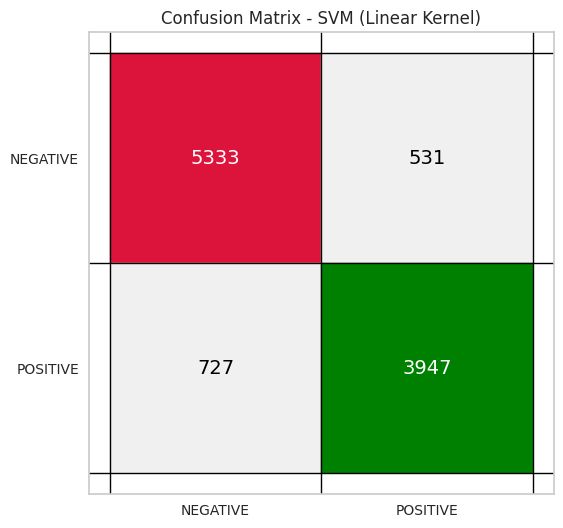

In [20]:
# ===============================
# Confusion Matrix Visualization
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (labels ordered as NEGATIVE=0, POSITIVE=1)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))

# Define colors for cells: green for True Positive, red for True Negative, neutral gray for others
colors = np.full(cm.shape, '#f0f0f0')
colors[0, 0] = '#DC143C'  # True Negative (red)
colors[1, 1] = '#008000'  # True Positive (green)

# Draw colored matrix cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.fill_between([j, j+1], i, i+1, color=colors[i, j])

# Add counts inside cells with color contrast
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if colors[i, j] in ['#008000', '#DC143C'] else 'black'
        ax.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color=text_color, fontsize=14)

# Set axis ticks and labels
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['NEGATIVE', 'POSITIVE'])
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(['NEGATIVE', 'POSITIVE'])

# Draw grid lines for better readability
for i in range(3):
    ax.axhline(i, color='black', linewidth=1)
    ax.axvline(i, color='black', linewidth=1)

ax.invert_yaxis()  # Invert y-axis to match matrix layout
ax.grid(False)
plt.title("Confusion Matrix - SVM (Linear Kernel)")
plt.show()


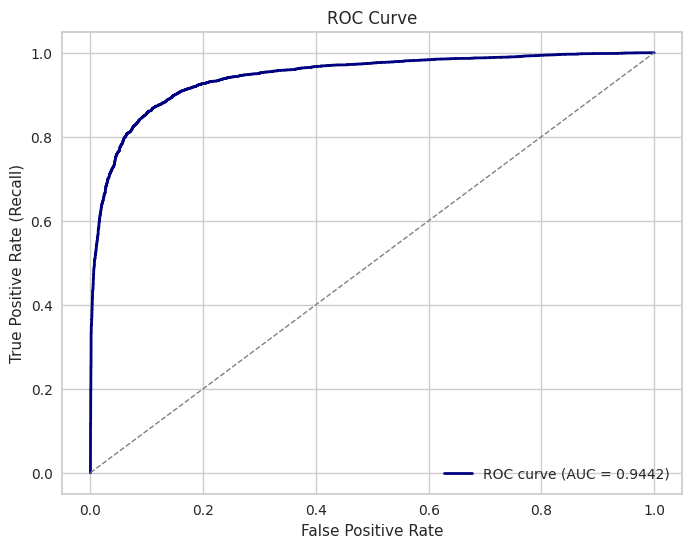

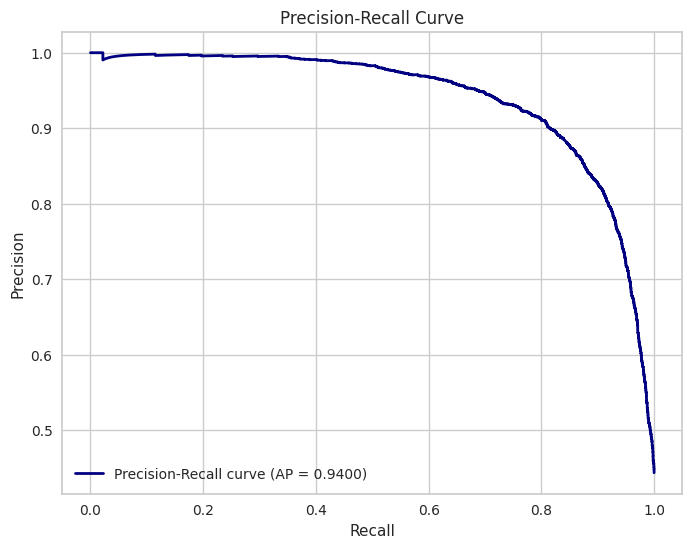

In [21]:
# ===============================
# ROC and Precision-Recall Curves
# ===============================

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtain predicted probabilities for positive class
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#000080', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate Precision-Recall curve and Average Precision score
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#000080', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# **Text Clustering**

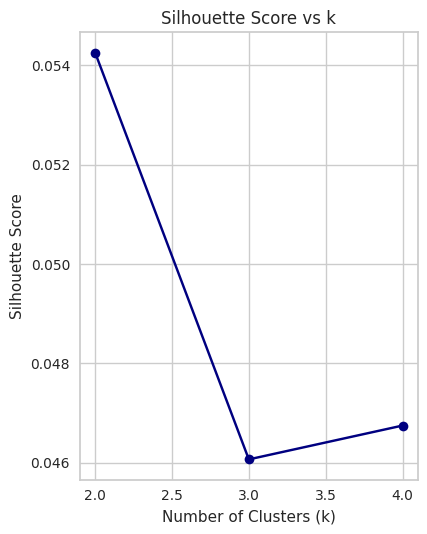

In [22]:
# ===============================
# K-Means Clustering Evaluation (Elbow + Silhouette)
# ===============================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
k_range = range(2, 5)  # You can extend the range if needed

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sbert)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest centroid (inertia)
    silhouette_scores.append(silhouette_score(X_sbert, labels))


# --- Plot Silhouette Scores ---
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='#000080')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


In [23]:
# ===============================
# Final Clustering with k=2
# ===============================

# Fit final KMeans model with 2 clusters (based on Silhouette Score or known label structure)
kmeans_sbert = KMeans(n_clusters=2, random_state=42)
clusters_sbert = kmeans_sbert.fit_predict(X_sbert)

# Evaluate clustering quality
silhouette_avg_sbert = silhouette_score(X_sbert, clusters_sbert)
print(f"Silhouette Score (k=2): {silhouette_avg_sbert:.6f}")

# Attach clusters to original DataFrame
data_cleaned['Cluster'] = clusters_sbert

Silhouette Score (k=2): 0.054254


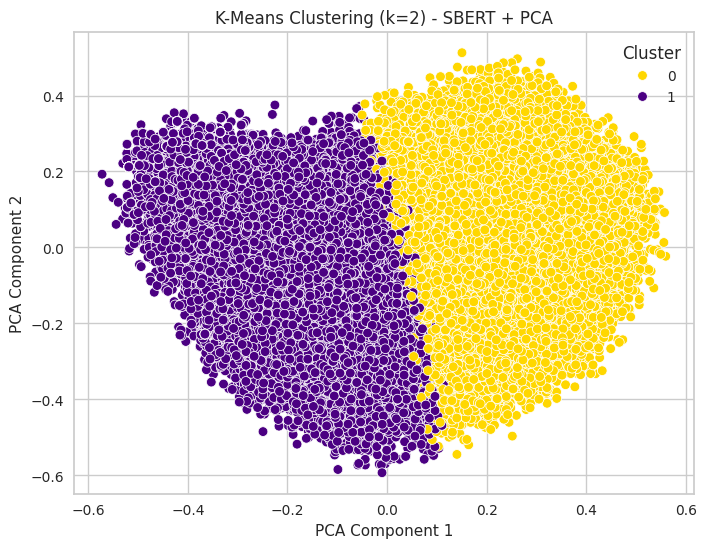

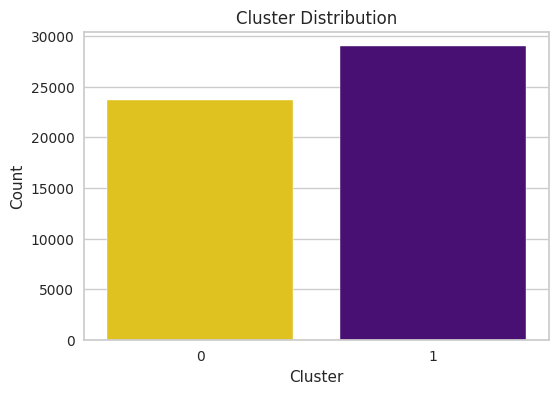

In [24]:
# ===============================
# Cluster Visualization using PCA
# ===============================

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sbert)

# Plot clustering result with PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_sbert, palette=['#FFD700', '#4B0082'])
plt.title("K-Means Clustering (k=2) - SBERT + PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

# --- Cluster Count Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x=clusters_sbert, palette=['#FFD700', '#4B0082'])
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()

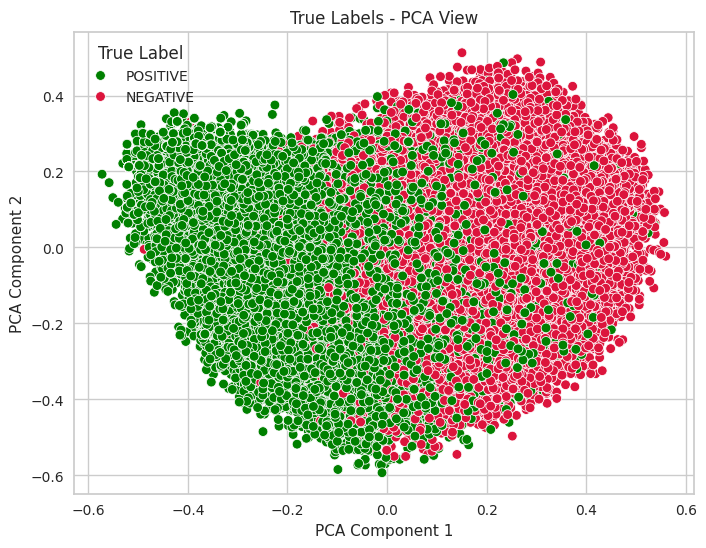


Contingency Table (True Label vs Cluster):
Cluster       0      1    All
label                        
NEGATIVE  21399   8024  29423
POSITIVE   2293  20970  23263
All       23692  28994  52686


In [25]:
# ===============================
# Clustering vs True Labels
# ===============================

# Visualize true labels in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_cleaned['label'],
                palette={'POSITIVE': '#008000', 'NEGATIVE': '#DC143C'})
plt.title("True Labels - PCA View")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='True Label')
plt.show()

# Cross-tabulation between true labels and assigned clusters
print("\nContingency Table (True Label vs Cluster):")
print(pd.crosstab(data_cleaned['label'], data_cleaned['Cluster'], margins=True))

In [26]:
# ===============================
# Clustering Metrics
# ===============================

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

# Compare clustering with ground truth
ari = adjusted_rand_score(data_cleaned['label'], clusters_sbert)
nmi = normalized_mutual_info_score(data_cleaned['label'], clusters_sbert)

print(f"\nAdjusted Rand Index (ARI): {ari:.6f}")
print(f"Normalized Mutual Information (NMI): {nmi:.6f}")

# Internal clustering validation scores
calinski_harabasz = calinski_harabasz_score(X_sbert, clusters_sbert)
davies_bouldin = davies_bouldin_score(X_sbert, clusters_sbert)

print(f"Calinski-Harabasz Score: {calinski_harabasz:.6f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.6f}")


Adjusted Rand Index (ARI): 0.370002
Normalized Mutual Information (NMI): 0.318268
Calinski-Harabasz Score: 3167.709717
Davies-Bouldin Score: 4.033714


# **Topic Modeling**

In [27]:
# ===============================
# Install & Import Dependencies
# ===============================


!pip install bertopic

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 3.9 MB/s eta 0:00:00


In [28]:
# ===============================
# Topic Modeling per Cluster using BERTopic
# ===============================

# Initialize SBERT model for embeddings
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Dictionary to store models and results for each cluster
cluster_topics = {}

# Loop over each cluster and apply BERTopic
for cluster_id in data_cleaned['Cluster'].unique():
    # Get all reviews for this cluster
    cluster_text = data_cleaned[data_cleaned['Cluster'] == cluster_id]['Cleaned_Review'].dropna()

    # Generate SBERT embeddings
    embeddings = sbert_model.encode(cluster_text.tolist(), show_progress_bar=True)

    # Apply BERTopic
    topic_model = BERTopic(embedding_model=sbert_model, verbose=False)
    topics, probs = topic_model.fit_transform(cluster_text.tolist(), embeddings)

    # Store the results
    cluster_topics[cluster_id] = {
        "model": topic_model,
        "topics": topics,
        "probs": probs
    }

Batches:   0%|          | 0/907 [00:00<?, ?it/s]

Batches:   0%|          | 0/741 [00:00<?, ?it/s]

In [29]:
# ===============================
# Print Topic Info per Cluster
# ===============================

for i in data_cleaned['Cluster'].unique():
    topic_info = cluster_topics[i]['model'].get_topic_info()

    if 'Name' in topic_info.columns:
        topic_info.drop('Name', axis=1, inplace=True)

    # Remove general Topic -1
    topic_info = topic_info[topic_info['Topic'] != -1]

    # Compute relative % of documents per topic
    total_docs = topic_info['Count'].sum()
    topic_info['% of Reviews'] = topic_info['Count'] * 100 / total_docs

    # Drop unused columns and rename
    topic_info = topic_info.drop(['Topic', 'Count'], axis=1)
    topic_info.rename(columns={'Representative_Docs': 'Top Words'}, inplace=True)

    # Print result
    print(f"\n--- Topics for Cluster {i} ---")
    print(f"Documents with associated topics: {total_docs} out of {len(data_cleaned[data_cleaned['Cluster'] == i])}")
    with pd.option_context('display.max_colwidth', 100):
        print(topic_info.head(10))
    print('\n')


--- Topics for Cluster 1 ---
Documents with associated topics: 19147 out of 28994
                                                                                       Representation  \
1             [podcasts, podcast, joe, rogan, speech, misinformation, episodes, support, neil, young]   
2                [lyrics, english, korean, sing, language, feature, karaoke, along, lyric, romanized]   
3            [playlists, playlist, create, make, making, creating, easy, made, recommendations, love]   
4                                         [good, ts, primuim, ita, soft, indeed, op, ya, general, bc]   
5                               [stars, star, give, five, gave, giving, would, rate, rating, deserve]   
6              [premium, worth, bought, without, buy, cheap, premiums, goated, expensive, affordable]   
7                                     [apps, appit, appi, one, ive, tried, used, best, superior, far]   
8                  [playlists, premium, playlist, shuffle, worth, play, get, 

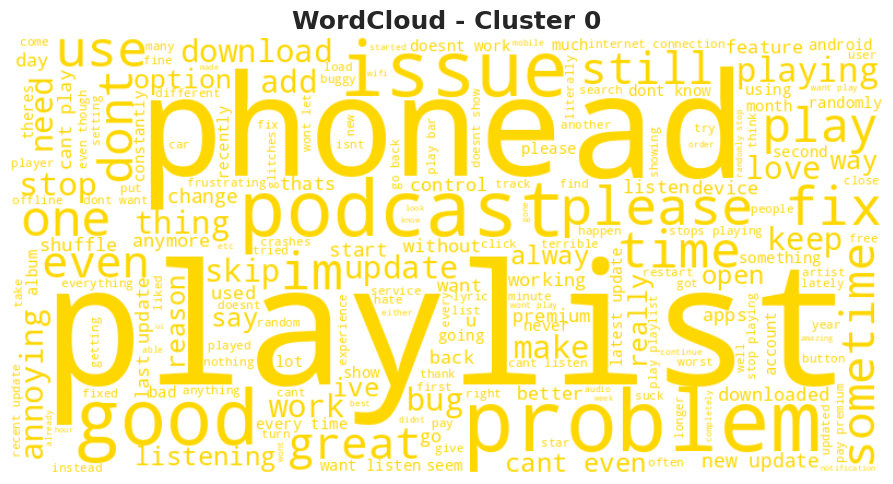

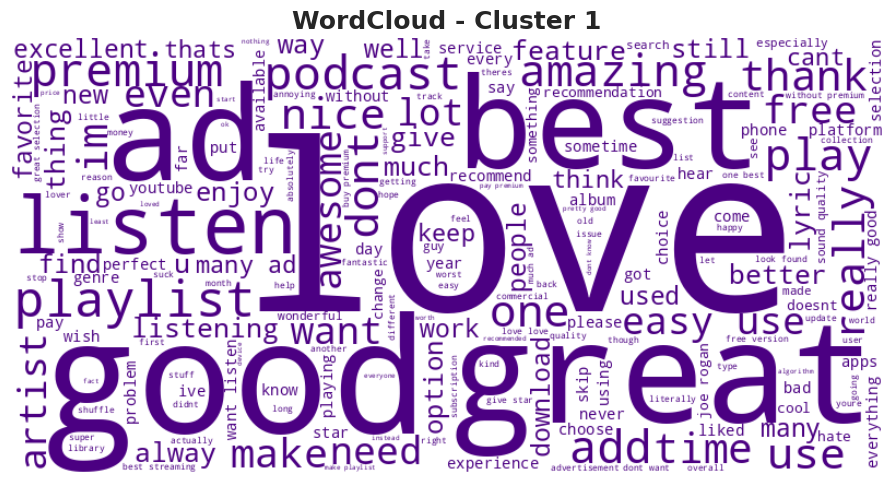

In [30]:
# ===============================
# WordCloud Visualization per Cluster
# ===============================

# Define colors for each cluster
cluster_colors = ['#FFD700', '#4B0082']

# Number of clusters
n_clusters = data_cleaned['Cluster'].nunique()

# Generate a WordCloud for each cluster
for i in range(n_clusters):
    cluster_text = ' '.join(data_cleaned[data_cleaned['Cluster'] == i]['Cleaned_Review'])

    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        width=800,
        height=400,
        contour_width=2,
        contour_color='black'
    ).generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: cluster_colors[i % len(cluster_colors)]),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - Cluster {i}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()